In [29]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import contextily as cx
import osmnx
from tqdm import tqdm
from shapely import distance

templos catolicos

In [4]:
df_cat = pd.read_csv('templosCatolicos_ayuntamientoMadrid.csv', delimiter=';', encoding='latin')
df_cat.head()

,PK,NOMBRE,DESCRIPCION-ENTIDAD,HORARIO,EQUIPAMIENTO,TRANSPORTE,DESCRIPCION,ACCESIBILIDAD,CONTENT-URL,NOMBRE-VIA,...,COD-DISTRITO,DISTRITO,COORDENADA-X,COORDENADA-Y,LATITUD,LONGITUD,TELEFONO,FAX,EMAIL,TIPO
0,3557,Basílica Jesús de Medinaceli,NaN,NaN,NaN,"Metro: Antón Martín (línea 1), Banco de España...",NaN,3,http://www.madrid.es/sites/v/index.jsp?vgnextc...,JESUS,...,1.0,CENTRO,440983.0,4473943.0,40.414026,-3.695601,914 299 375 / 914 296 893,NaN,jesusmedinaceli@archimadrid.es,/contenido/entidadesYorganismos/TemplosIglesia...
1,3394,Basílica La Milagrosa,NaN,NaN,NaN,"Metro: Alonso Cano (línea 7), Gregorio Marañón...",NaN,3,http://www.madrid.es/sites/v/index.jsp?vgnextc...,GARCIA DE PAREDES,...,7.0,CHAMBERI,440994.0,4476465.0,40.436746,-3.695713,914 473 248 / 914 473 249,NaN,parroquialamilagrosa@archimadrid.es,/contenido/entidadesYorganismos/TemplosIglesia...
2,3371,Basílica Pontificia de San Miguel,NaN,NaN,NaN,"Metro: Sol (líneas 1, 2 y 3), Tirso de Molina ...",NaN,3,http://www.madrid.es/sites/v/index.jsp?vgnextc...,SAN JUSTO,...,1.0,CENTRO,439790.0,4473973.0,40.414205,-3.709661,915 484 011,NaN,info@bsmiguel.es,/contenido/entidadesYorganismos/MonumentosEdif...
3,18319,Capilla de San Ignacio de los Vascos,NaN,NaN,NaN,"Metro: Antón Martín (Línea,1), Sol (líneas 1, ...",NaN,3,http://www.madrid.es/sites/v/index.jsp?vgnextc...,PRINCIPE,...,1.0,CENTRO,440602.0,4473981.0,40.414334,-3.700097,914 297 236,NaN,NaN,/contenido/entidadesYorganismos/TemplosIglesia...
4,11242837,Capilla de San Isidro,NaN,"Día 4 de cada mes (si coincide con un sábado, ...",NaN,"Metro: La Latina (línea 5), Puerta de Toledo (...",Tarifa gratuita. Descripción monumental: el ...,1,http://www.madrid.es/sites/v/index.jsp?vgnextc...,AGUILA,...,1.0,CENTRO,439593.0,4473511.0,40.410035,-3.711938,913 650 841 / 650 779 950,NaN,info@cementeriodesanisidro.com,/contenido/entidadesYorganismos/MonumentosEdif...


In [5]:
df_cat[['LATITUD', 'LONGITUD']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LATITUD   380 non-null    float64
 1   LONGITUD  380 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB


there are five entries that do not have lat, long coordinates.

In [6]:
df_cat = df_cat.dropna(subset=['LATITUD', 'LONGITUD'])

gdf_cat = df_cat.copy()
gdf_cat['geometry'] = gdf_cat[['LATITUD', 'LONGITUD']].apply(lambda x : Point(x['LONGITUD'], x['LATITUD']), axis=1)
gdf_cat = gdf_cat.set_geometry('geometry')
gdf_cat = gdf_cat.set_crs('EPSG:4326')
gdf_cat = gdf_cat.drop_duplicates(subset='geometry')
gdf_cat.to_file('templosCatolicos.geojson')

templos no catolicos

In [7]:
df_noCat = pd.read_csv('templosNoCatolicos_ayuntamientoMadrid.csv', delimiter=';', encoding='latin')

gdf_noCat = df_noCat.copy()
gdf_noCat['geometry'] = gdf_noCat[['LATITUD', 'LONGITUD']].apply(lambda x : Point(x['LONGITUD'], x['LATITUD']), axis=1)
gdf_noCat = gdf_noCat.set_geometry('geometry')
gdf_noCat = gdf_noCat.set_crs('EPSG:4326')
gdf_noCat = gdf_noCat.sort_values(['geometry', 'DESCRIPCION-ENTIDAD']).drop_duplicates(subset='geometry', keep='first')

gdf_noCat.to_file('templosNoCatolicos.geojson')

In [ ]:
gdf_allTemplos = pd.concat([gdf_cat, gdf_noCat])

# temples with OSM

In [26]:
gdf_templosOSM = osmnx.features_from_place(
    query='Community of Madrid',
    tags = {'amenity' : 'place_of_worship'}
).loc[:, ['geometry', 'amenity', 'name', 'religion']]

gdf_templosOSM = gdf_templosOSM.to_crs('EPSG:3035')

gdf_templosOSM['geometry'] = gdf_templosOSM['geometry'].centroid

gdf_templosOSM = gdf_templosOSM.to_crs('EPSG:32630')

In [27]:
gdf_templosOSM.head(1)

,,geometry,amenity,name,religion
element,id,,,,
node,26261496,POINT (439582.887 4480841.682),place_of_worship,Parroquia Nuestra Señora de Luján,christian


In [25]:
gdf_allTemplos.head(1)

,PK,NOMBRE,DESCRIPCION-ENTIDAD,HORARIO,EQUIPAMIENTO,TRANSPORTE,DESCRIPCION,ACCESIBILIDAD,CONTENT-URL,NOMBRE-VIA,...,DISTRITO,COORDENADA-X,COORDENADA-Y,LATITUD,LONGITUD,TELEFONO,FAX,EMAIL,TIPO,geometry
0,3557,Basílica Jesús de Medinaceli,NaN,NaN,NaN,"Metro: Antón Martín (línea 1), Banco de España...",NaN,3,http://www.madrid.es/sites/v/index.jsp?vgnextc...,JESUS,...,CENTRO,440983.0,4473943.0,40.414026,-3.695601,914 299 375 / 914 296 893,NaN,jesusmedinaceli@archimadrid.es,/contenido/entidadesYorganismos/TemplosIglesia...,POINT (-3.6956 40.41403)


In [28]:
gdf_templosOSM = gdf_templosOSM.reset_index()
gdf_templosOSM = gdf_templosOSM.drop(['element', 'amenity'], axis=1)
gdf_templosOSM = gdf_templosOSM.rename({'name' : 'NOMBRE', 'id' : 'PK', 'religion' :'DESCRIPCION-ENTIDAD'}, axis=1)
gdf_templosOSM.head(1)

,PK,geometry,NOMBRE,DESCRIPCION-ENTIDAD
0,26261496,POINT (439582.887 4480841.682),Parroquia Nuestra Señora de Luján,christian


100%|██████████| 1260/1260 [00:18<00:00, 66.78it/s]


total rows added : 671


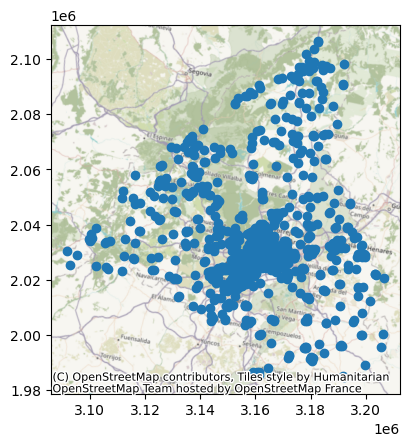

In [30]:
gdf_allTemplos = gdf_allTemplos.to_crs('EPSG:3035')
gdf_templosOSM = gdf_templosOSM.to_crs('EPSG:3035')

gdf_templosTodo = gdf_allTemplos.copy()

i = 0
for row in tqdm(gdf_templosOSM.iterrows(), total=gdf_templosOSM.shape[0]):
    valid = True
    row = row[1]
    for libInSet in gdf_templosTodo['geometry']:
        if distance(row.geometry, libInSet) <= 200:
            valid = False
            break
    
    if valid:
        gdf_templosTodo = pd.concat([ gdf_templosTodo, gpd.GeoDataFrame(row).transpose().set_geometry('geometry').set_crs('EPSG:3035') ])
        i = i + 1

print(f'total rows added : {i}')

ax = gdf_templosTodo.plot()
cx.add_basemap(crs= gdf_templosTodo.crs, ax = ax)

In [33]:
gdf_templosTodo.to_file('./cleaned/templosMadrid.geojson')